In [10]:
import matplotlib.pyplot  as plt
import numpy as np
%matplotlib inline
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

We are trying to perform a density based anomaly detection. The idea is that normal observations will follow same distribution and
datapoints which are far away can be classified as anomalies. DB scan also follows the same principle but we need to provide epsilon 
and minimum points  for that . The same kind of CV can be applied to find optimal values for epsilon.

In [59]:
# reading the data and returning dataFrame
def getDataset(filepath):
    df = pd.read_csv(filepath)
    return df
# normalizing the vars
def feature_normalize(df):
    mu = np.mean(df,axis=0)
    sd =np.std(df,axis=0)
    df = (df-mu)/sd
    return df
# getting the mean and sigma of the underlying distribution to get probabilities distribution for data points
def estimateGaussian(df):
    mu = np.mean(df,axis=0)
    sigma = np.cov(df.T)
    return mu,sigma
# getting probabilities for available data points to compare with a threshold  to classify the anomalies
def multiVariateGaussian(df,mu,sigma):
    p = multivariate_normal(mean=mu,cov =sigma)
    return p.pdf(df)


In [77]:
# this function takes two arguments, 1- probabilities of individual points and  label to indicate whether these are normal 
# or anamolies and select epsilon value for which we have maximum F1-Score
# (the probability value which seperates anmolie from normally distributed values).

def getThresholdByCV(Probs,gt):
    f =0
    best_epsilon =0
    stepSize = (max(Probs)-min(Probs))/1000
    epsilonRange = np.arange(min(Probs),max(Probs),stepSize)
    for e in np.nditer(epsilonRange):
        tmpProb = (Probs<e)
        fScore = f1_score(gt,tmpProb,average="binary")
        if fScore>f:
            f =fScore
            best_epsilon =e
    return f,best_epsilon
    

In [78]:
#reading the data
trainData = getDataset("D:/Hackethon/anamolyDetection/tr_server_data.csv")
testData =  getDataset("D:/Hackethon/anamolyDetection/cv_server_data.csv")
classData = getDataset("D:/Hackethon/anamolyDetection/gt_server_data.csv")

In [81]:
trainData.columns = ["Latency","Throughput"]
testData.columns = ["Latency","Throughput"]
classData.columns =["class"]
classData["class"] = classData["class"].astype("int")

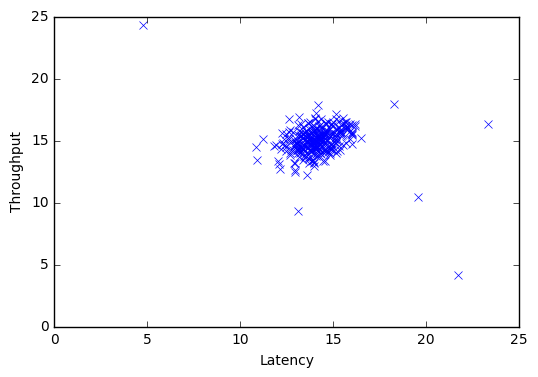

In [82]:
plt.figure()
plt.plot(trainData.iloc[:,0],trainData.iloc[:,1],"bx")
plt.xlabel("Latency")
plt.ylabel("Throughput")
plt.show()

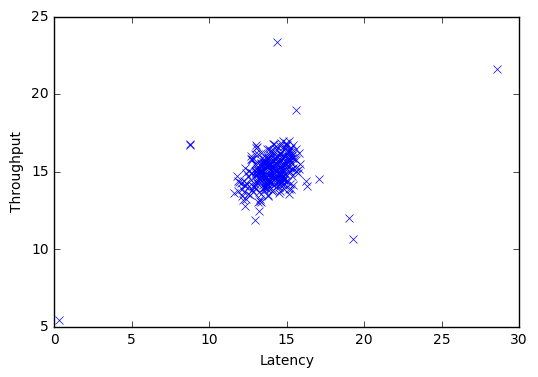

In [83]:
plt.figure()
plt.plot(testData.iloc[:,0],testData.iloc[:,1],"bx")
plt.xlabel("Latency")
plt.ylabel("Throughput")
plt.show()

In [84]:
#We see a few observations which are not included in the cluster like shape and for these the probabilities of belonging to this
#  distribution should be low

mu, sigma = estimateGaussian(trainData)
p = multiVariateGaussian(trainData,mu,sigma)

In [85]:
mu

Latency       14.115734
Throughput    14.998513
dtype: float64

(array([13., 10., 17., 22., 23., 34., 27., 47., 49., 64.]),
 array([3.05072717e-21, 9.01248202e-03, 1.80249640e-02, 2.70374461e-02,
        3.60499281e-02, 4.50624101e-02, 5.40748921e-02, 6.30873741e-02,
        7.20998561e-02, 8.11123382e-02, 9.01248202e-02]),
 <a list of 10 Patch objects>)

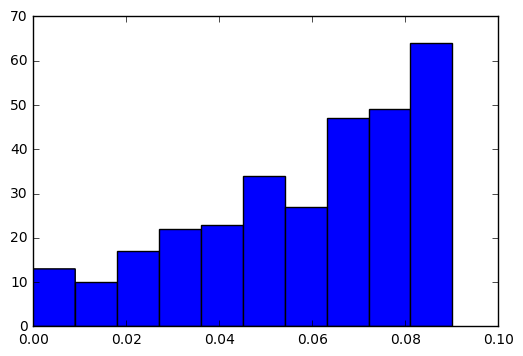

In [86]:
plt.hist(p)

(array([12.,  8., 19., 16., 30., 31., 27., 45., 60., 58.]),
 array([9.95705001e-41, 9.01697808e-03, 1.80339562e-02, 2.70509342e-02,
        3.60679123e-02, 4.50848904e-02, 5.41018685e-02, 6.31188466e-02,
        7.21358246e-02, 8.11528027e-02, 9.01697808e-02]),
 <a list of 10 Patch objects>)

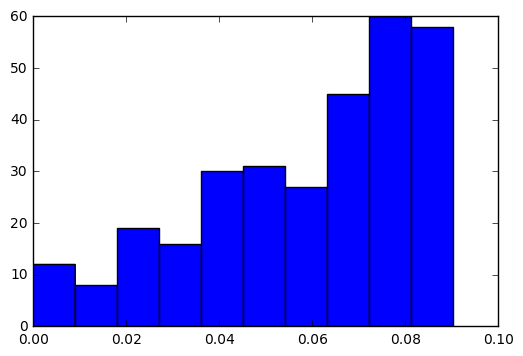

In [87]:
p = multiVariateGaussian(testData,mu,sigma)
plt.hist(p)

Probability distribution for both train and test seems similar
We are considering that train and test datasets are drawn from same population and they have similar mean and SD

In [88]:
trainData = feature_normalize(trainData)
testData =feature_normalize(testData)

In [91]:
f,e =getThresholdByCV(p,classData["class"])

C:\Users\anurag dubey\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [180]:
outliers = np.where(p<e)
outlierLs = []
for o in outliers[0]:
    outlierLs.append(o)
outlierLs

[299, 300, 301, 302, 303, 304, 305]

<function matplotlib.pyplot.show>

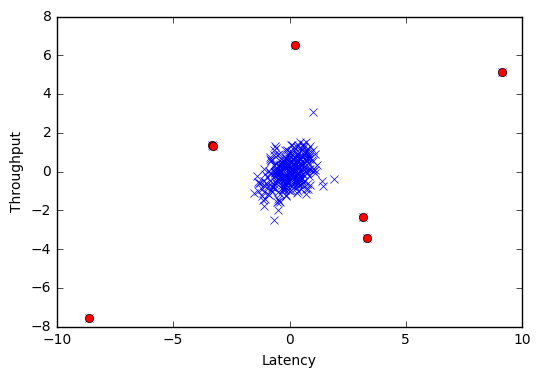

In [183]:
plt.plot(testData.iloc[:,0],testData.iloc[:,1],"bx") 
plt.plot(testData.iloc[outlierLs,0],testData.iloc[outlierLs,1],"ro")
plt.xlabel("Latency")
plt.ylabel("Throughput")
plt.show

In [184]:
print ("best F1-Score %.2f is achived on Epsilon Prob %.2f" % (f,e) )

best F1-Score 0.88 is achived on Epsilon Prob 0.00


 we got an F1 scroe of .88 using the above method and found 6 outliers/Anamolies( highlighted in red)